# Create GCM like outputs from RCM data:

## Setting up:

In [1]:
# run script that installs missing libraries
#! chmod 755 scripts.sh
#! ./scripts.sh

### Imports

In [2]:
import os
from matplotlib import pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cf_units
from datetime import datetime
from datetime import timedelta
import rasterio
import cartopy.crs as ccrs

import pyproj
from pyproj import Transformer
from google.cloud import storage

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
PROJECT = 'ee-iceshelf-gee4geo'
BUCKET = "ee-downscalingclimatemodels"

In [4]:
# Google cloud
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

## Read data:

### GCM:
Read GCM that was reprojected on polar stereographic coordinates

In [11]:
# Access file
globalName = 'ee-downscalingclimatemodels/year_ACCESS1-3-stereographic.zarr'

# open from google cloud
GCM_xy = xr.open_zarr('gs://'+globalName)
# indicate projection crs
GCM_xy = GCM_xy.rio.write_crs("epsg:3031")
print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(GCM_xy.x.max().data, 
                                                                     GCM_xy.x.min().data, 
                                                                     GCM_xy.y.max().data, 
                                                                     GCM_xy.y.min().data))
GCM_xy.load()

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


<xarray.Dataset>
Dimensions:         (plev: 4, bnds: 2, time: 151, y: 148, x: 176)
Coordinates:
  * plev            (plev) float64 5e+04 6e+04 7e+04 8.5e+04
    spatial_ref     int64 0
  * time            (time) datetime64[ns] 1950-06-30 1951-06-30 ... 2100-06-30
  * x               (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y               (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
Dimensions without coordinates: bnds
Data variables:
    PLEV12_15_bnds  (plev, bnds) float64 4.5e+04 5.5e+04 ... 7.75e+04 8.875e+04
    TA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    TAS             (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    TIME2_bnds      (time, bnds) float64 0.0 11.0 12.0 ... 1.8e+03 1.811e+03
    UA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    VA              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
    ZG              (time, plev, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    CDI:                       Climate Data Interface version 1.9.7.1 (http:/...
    CDO:                       Climate Data Operators version 1.9.7.1 (http:/...
    Conventions:               CF-1.6
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    crs:                       4326
    frequency:                 year
    history:                   Fri May 15 15:08:09 2020: cdo yearmean ACCESS1...
    nco_openmp_thread_number:  1

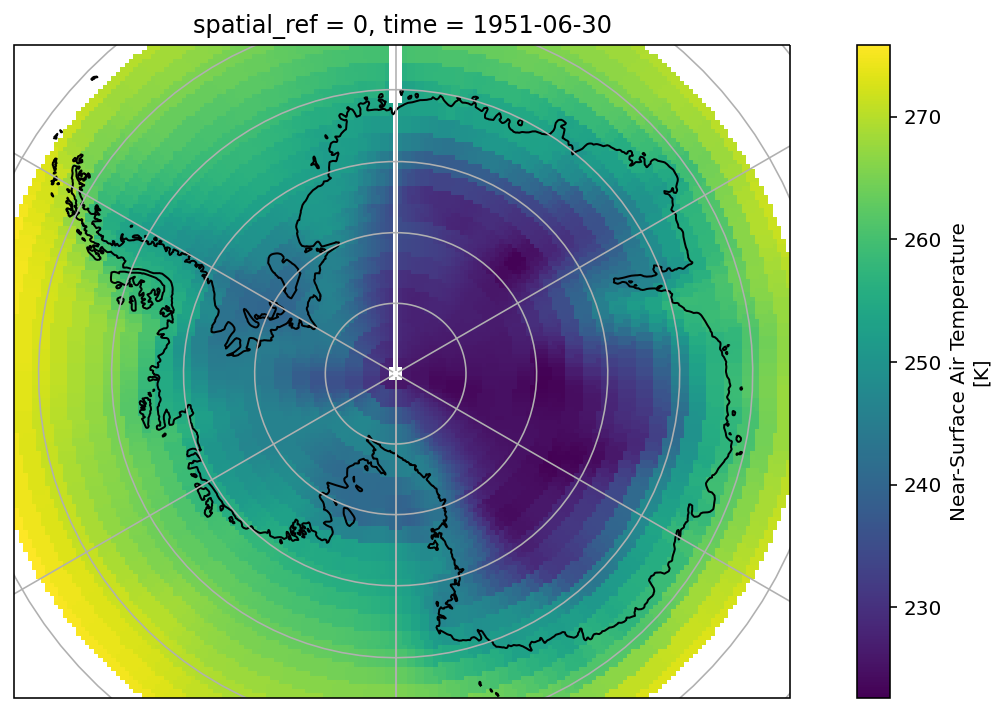

In [12]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = GCM_xy.TAS.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines()
ax.gridlines()

### RCM:

In [57]:
localName = 'ee-downscalingclimatemodels/year-MAR_ACCESS1.3-1980-2100_zen.zarr'
dsr = xr.open_zarr('gs://'+localName)
RCM = dsr.rename({'X':'x', 'Y':'y','TIME':'time'})

# indicate projection crs
RCM_xy = RCM.rio.write_crs("epsg:3031")

# Convert RCM from km to m for plots:
RCM_xy['x'] = RCM_xy.x*1000
RCM_xy['y'] = RCM_xy.y*1000
RCM_xy.x.attrs['units'] = 'm'
RCM_xy.y.attrs['units'] = 'm'

# Remove SECTOR dimension:
RCM_xy['SMB'] = RCM_xy.SMB.mean(dim='SECTOR1_1')
RCM_xy['RU'] = RCM_xy.RU.mean(dim='SECTOR1_1')
RCM_xy['SU'] = RCM_xy.SU.mean(dim='SECTOR1_1')

# drop irrelevant sector dimension
RCM_xy = RCM_xy.drop_dims('SECTOR1_1')

print('Max and min values of x: {}m -> {}m and y: {}m -> {}m'.format(RCM_xy.x.max().data, 
                                                                     RCM_xy.x.min().data, 
                                                                     RCM_xy.y.max().data, 
                                                                     RCM_xy.y.min().data))
RCM_xy.load()

Max and min values of x: 3115000.25m -> -3010000.25m and y: 2590000.0m -> -2555000.0m


<xarray.Dataset>
Dimensions:      (time: 121, y: 148, x: 176, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 1980-07-02 ... 2100-07-02T12:00:00
  * x            (x) float32 -3.01e+06 -2.975e+06 ... 3.08e+06 3.115e+06
  * y            (y) float32 -2.555e+06 -2.52e+06 ... 2.555e+06 2.59e+06
    spatial_ref  int64 0
Dimensions without coordinates: bnds
Data variables:
    RF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    RU           (time, y, x) float32 inf inf inf inf inf ... inf inf inf inf
    SF           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SMB          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    SU           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TIME_bnds    (time, bnds) datetime64[ns] 1980-01-01 ... 2101-01-01
Attributes:
    Conventions:       CF-1.6
    NCO:               netCDF Operators version 4.8.1 (Homepage = http://nco....
    contact:           ckittel@uliege.be
    creation_date:     2021-01-23-T13:24:17Z
    driving_model_id:  ACCESS1.3
    institute_id:      ULg
    institution:       University of Liege - Belgium
    reference:         http://www.climato.be
    tracking_id:       ddbf4239bdd46d1127a1bf5625cf2bc0

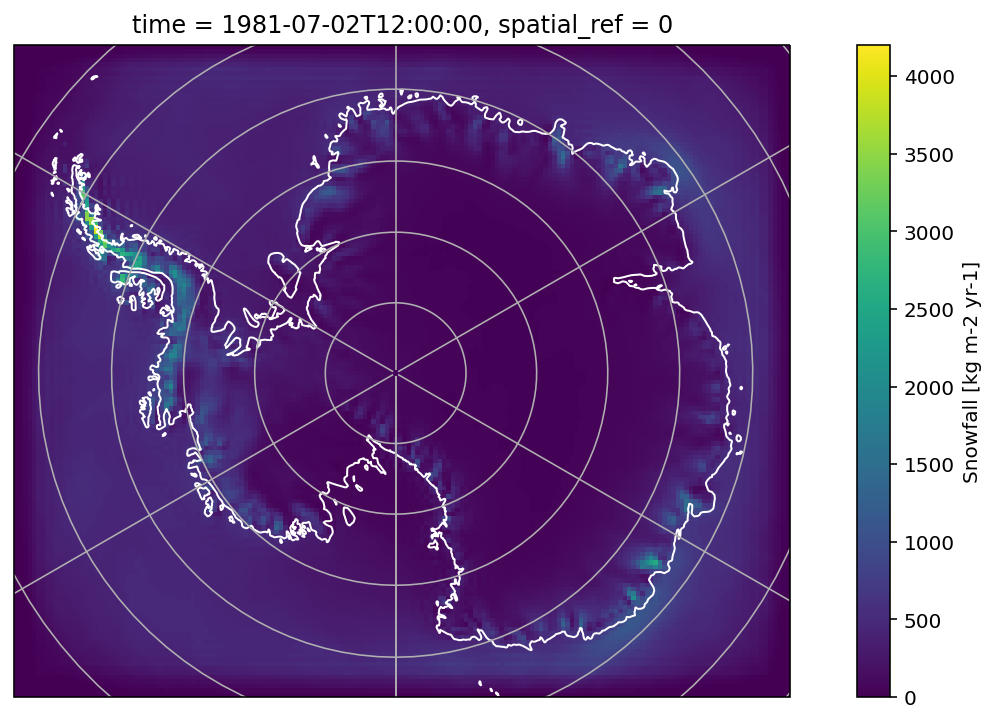

In [58]:
# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = RCM_xy.SF.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines(color = 'w')
ax.gridlines()

## GCM like data:
Reproject RCM to match GCM resolution.
`rio.reproject_match` will reproject to match the resolution, projection, and region of another raster. 

In [63]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [64]:
print("GCM with crs x/y:\n----------------\n")
print_raster(GCM_xy.TAS)
print("RCM with crs x/y:\n----------------\n")
print_raster(RCM_xy.SF)

GCM with crs x/y:
----------------

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 911105408.0
CRS: EPSG:3031

RCM with crs x/y:
----------------

shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 874292928.0
CRS: EPSG:3031



shape: (148, 176)
resolution: (35000.002857142856, 35000.0)
bounds: (-3027500.2514285715, 2607500.0, 3132500.2514285715, -2572500.0)
sum: 874292928.0
CRS: EPSG:3031



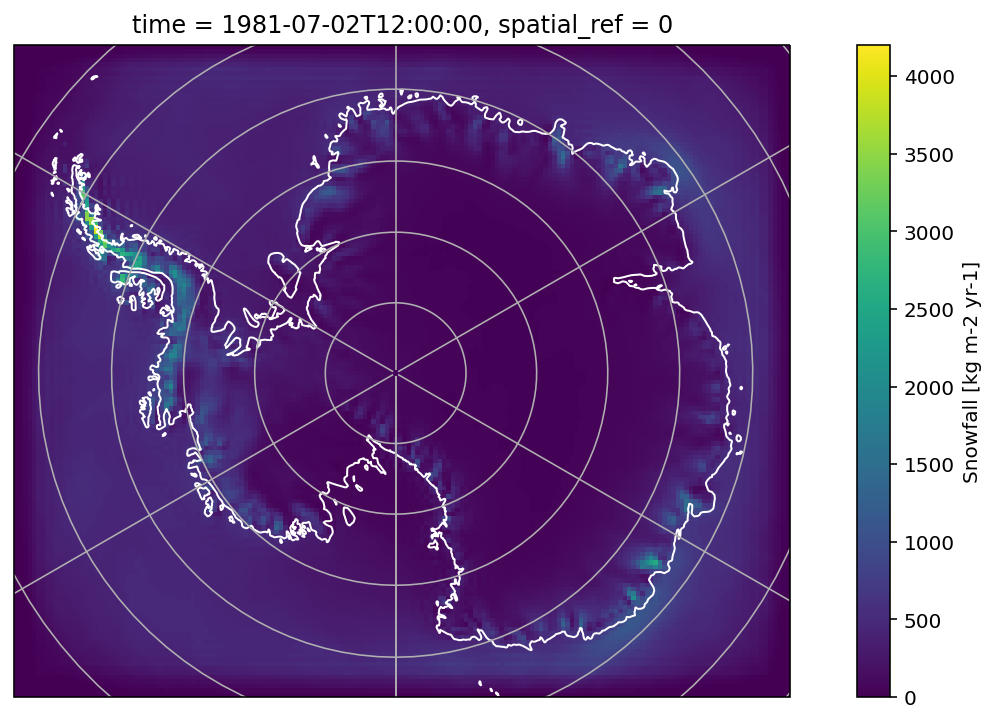

In [69]:
# Reproject SF R
SF_reproj = RCM_xy.SF.rio.reproject_match(GCM_xy.TAS)
print_raster(SF_reproj)

# map
map_proj = ccrs.SouthPolarStereo(central_longitude=0)
ax = plt.axes(projection=map_proj)

p = SF_reproj.isel(time = 1).plot(x='x', y='y',
                                 subplot_kws={"projection": map_proj}, 
                                 transform=ccrs.SouthPolarStereo()); # data
ax.coastlines(color = 'w')
ax.gridlines()

In [ ]:
TAS_xy = TAS_latlon.rio.reproject_match(SF_xy)
print("GCM crs EPSG:3031 x/y:\n----------------\n")
print_raster(TAS_xy)

print("RCM crs EPSG:3031 x/y:\n----------------\n")
print_raster(SF_xy)

TAS_xy.load()